# Environment Setup

In [2]:
# =========================
# CELL 0.1 — Mount Drive and set working directory (persistent)
# =========================
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/Options Pricing Research (S26)/machine_learning_for_options_pricing_and_implied_volatility")
print("cwd =", os.getcwd())

Mounted at /content/drive
cwd = /content/drive/MyDrive/Options Pricing Research (S26)/machine_learning_for_options_pricing_and_implied_volatility


In [3]:
# =========================
# CELL 0.2 — Installs
# QMC (Latin Hypercube)
# =========================
try:
    from scipy.stats import qmc
    import scipy
    print("scipy version:", scipy.__version__)
    print("qmc available ✅")
except Exception as e:
    print("qmc not available, upgrading scipy... error was:", repr(e))
    !pip -q install --upgrade scipy
    import scipy
    print("scipy version after upgrade:", scipy.__version__)
    from scipy.stats import qmc
    print("qmc available ✅")

scipy version: 1.16.3
qmc available ✅


In [4]:
# =========================
# CELL 0.3 — Imports
# =========================

# Basic imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# QMC for Latin Hypercube Sampling
from scipy.stats import qmc

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, LinearLR, OneCycleLR, LambdaLR

# Utilities
import json, datetime, subprocess, os

In [5]:
# =========================
# CELL 0.4 — Reproducibility (global seeds)
# =========================
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("SEED =", SEED)

SEED = 42


In [6]:
# =========================
# CELL 0.5 — Run Logger (inline, saves everything to Drive under runs/)
# =========================
def _git_hash():
    try:
        return subprocess.check_output(["git", "rev-parse", "HEAD"]).decode().strip()
    except Exception:
        return "no-git"

def start_run(task: str, base_dir="runs"):
    run_id = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    run_dir = os.path.join(base_dir, task, run_id)
    fig_dir = os.path.join(run_dir, "figures")
    os.makedirs(fig_dir, exist_ok=True)

    meta = {
        "task": task,
        "run_id": run_id,
        "created_at": datetime.datetime.now().isoformat(),
        "git_commit": _git_hash(),
        "seed": SEED,
    }
    with open(os.path.join(run_dir, "meta.json"), "w") as f:
        json.dump(meta, f, indent=2)

    return run_dir, fig_dir

def save_json(run_dir: str, name: str, obj: dict):
    with open(os.path.join(run_dir, f"{name}.json"), "w") as f:
        json.dump(obj, f, indent=2)

def save_notes(run_dir: str, text: str):
    with open(os.path.join(run_dir, "notes.md"), "w") as f:
        f.write(text.strip() + "\n")

print("Logger ready ✅")

Logger ready ✅


# BS-ANN

## Closed-Form Formula

In [ ]:
# =========================
# CELL 1.0 — Week 2 START (creates a run folder for this week)
# =========================
run_dir, fig_dir = start_run("week2_bsm_basics")
print("run_dir:", run_dir)
print("fig_dir:", fig_dir)

save_json(run_dir, "params", {
    "week": 2,
    "goal": "BSM formula basics + equivalence of scaled vs unscaled + 2 plots",
    "plotA": "fix (tau,r,sigma), vary m=S/K, plot V/K",
    "plotB": "fix (m,tau,r), vary sigma, plot V/K",
})

save_notes(run_dir, """
Week 2 deliverable:
- Explain variables S,K,tau,r,sigma and what a European call payoff is.
- Explain why bs_price_call(S,K,...) and bs_moneyness_call(m=S/K,...) are equivalent.
- Plot A: V/K vs m with fixed tau,r,sigma (tau>0).
- Plot B: V/K vs sigma with fixed m,tau,r.
""")

run_dir: runs/week2_bsm_basics/20260126-003209
fig_dir: runs/week2_bsm_basics/20260126-003209/figures


In [ ]:
# =========================
# Week 2 — 1.1) BLACK–SCHOLES FORMULAE (PRICE + SCALED MONEYNESS VERSION)
# =========================

def bs_price_call(S, K, T, t, r, sigma):
  """
  Black-Sholes call option value price related to PDE (2). Returns option's price.
  S: spot price
  K: strike price
  T: time to maturity
  t: spot time
  r: interest rate
  sigma: volatility of underlying asset
  """

  # Boundary condition of Black-Sholes PDE (2)
  if T==t:
    return np.maximum(0,S-K)
  # Solution of the PDE (2) on the open interval [t, T)
  else :
    d1 = ( np.log(S / K) + (r + 0.5 * sigma ** 2) * (T-t) ) / (sigma * np.sqrt(T-t))
    d2 = d1 - sigma*np.sqrt(T-t)
    value = S * norm.cdf(d1) - K * np.exp(-r * (T-t)) * norm.cdf(d2)

  return value

def bs_moyeness_call(moyeness, tau, r, sigma):
  """
  Same function as bs_price_call but in terms of moyeness. Returns V/K and
  has S/K instead of two seperate paremeters S and K.
  moyeness: S/K
  Tau: time to maturity minus spot time
  r: interest rate
  sigma: volatility of underlying asset
  """

  d1 = ( np.log(moyeness) + (r + 0.5 * sigma ** 2) * (tau) ) / (sigma * np.sqrt(tau))
  d2 = d1 - sigma*np.sqrt(tau)
  value_moyeness = moyeness * norm.cdf(d1) - np.exp(-r * (tau)) * norm.cdf(d2)

  return value_moyeness

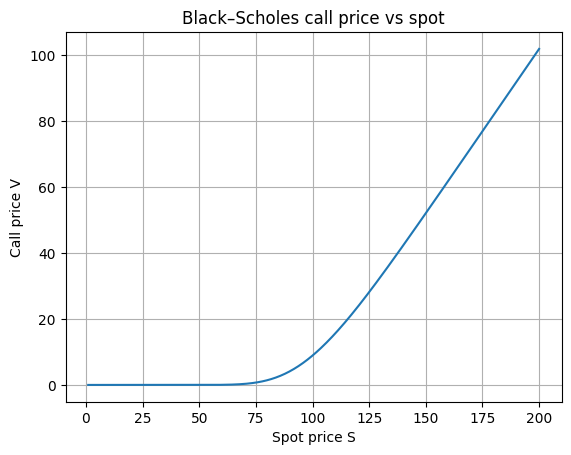

Saved: runs/week2_bsm_basics/20260126-003209/figures/plot0_price_vs_spot.png


In [ ]:
# =========================
# Week 2 — 1.2) VISUALIZATION: CALL PRICE AS A FUNCTION OF SPOT PRICE
# =========================

r, T, t, sigma, K = 0.02, 1.0, 0.0, 0.2, 100
S = np.linspace(1, 200, 400)

V = bs_price_call(S, K, T, t, r, sigma)

plt.figure()
plt.plot(S, V)
plt.xlabel("Spot price S")
plt.ylabel("Call price V")
plt.title("Black–Scholes call price vs spot")
plt.grid(True)

path = os.path.join(fig_dir, "plot0_price_vs_spot.png")
plt.savefig(path, dpi=180, bbox_inches="tight")
plt.show()

print("Saved:", path)

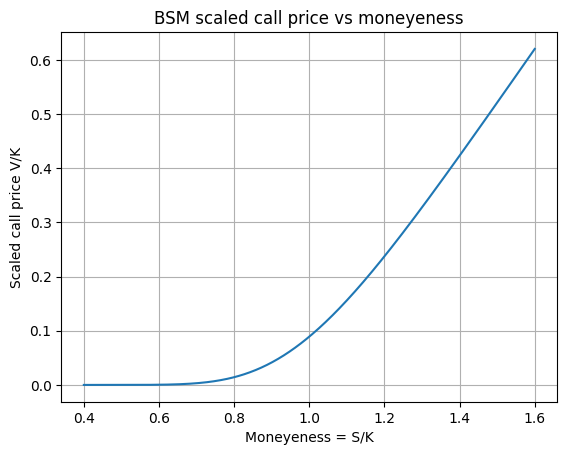

Saved: runs/week2_bsm_basics/20260126-003209/figures/plotA_VK_vs_moneyeness.png


In [ ]:
# =========================
# Week 2 — 1.3) PLOT A: SCALED CALL PRICE AS A FUNCTION OF MONEYNESS
# =========================

tau, r, sigma = 1.0, 0.02, 0.2
moneyeness = np.linspace(0.4, 1.6, 400)

vk = bs_moyeness_call(moneyeness, tau, r, sigma)

plt.figure()
plt.plot(moneyeness, vk)
plt.xlabel("Moneyeness = S/K")
plt.ylabel("Scaled call price V/K")
plt.title("BSM scaled call price vs moneyeness")
plt.grid(True)

path = os.path.join(fig_dir, "plotA_VK_vs_moneyeness.png")
plt.savefig(path, dpi=180, bbox_inches="tight")
plt.show()

print("Saved:", path)

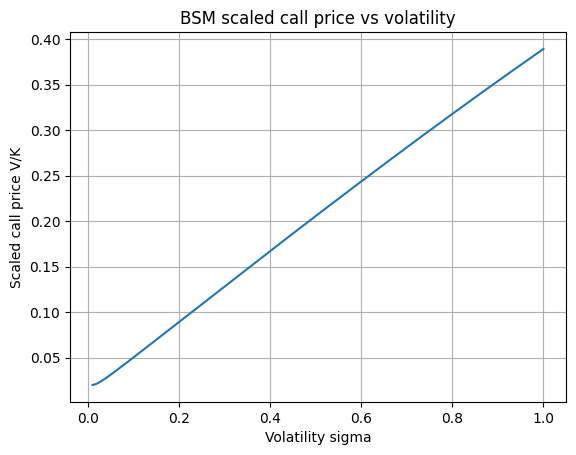

Saved: runs/week2_bsm_basics/20260126-003209/figures/plotB_VK_vs_sigma.png


In [ ]:
# =========================
# Week 2 — 1.4) PLOT B: SCALED CALL PRICE AS A FUNCTION OF VOLATILITY
# =========================

moyeness_fixed, tau, r = 1.0, 1.0, 0.02
sigmas = np.linspace(0.01, 1.0, 300)

vk2 = np.array([bs_moyeness_call(moyeness_fixed, tau, r, s) for s in sigmas])

plt.figure()
plt.plot(sigmas, vk2)
plt.xlabel("Volatility sigma")
plt.ylabel("Scaled call price V/K")
plt.title("BSM scaled call price vs volatility")
plt.grid(True)

path = os.path.join(fig_dir, "plotB_VK_vs_sigma.png")
plt.savefig(path, dpi=180, bbox_inches="tight")
plt.show()

print("Saved:", path)

In [ ]:
# =========================
# Week 2 — 1.5) EQUIVALENCE CHECK: (bs_price_call / K) == bs_moyeness_call(S/K)
# =========================

S0, K0, T0, t0, r0, sigma0 = 110, 100, 1.0, 0.0, 0.02, 0.2
tau0 = T0 - t0

vk_from_price = bs_price_call(S0, K0, T0, t0, r0, sigma0) / K0
vk_from_m = bs_moyeness_call(S0 / K0, tau0, r0, sigma0)
diff = float(abs(vk_from_price - vk_from_m))

print("V/K from bs_price_call:", float(vk_from_price))
print("V/K from bs_moyeness_call:", float(vk_from_m))
print("abs diff:", diff)

save_json(run_dir, "equivalence", {
    "inputs": {"S": S0, "K": K0, "T": T0, "t": t0, "r": r0, "sigma": sigma0},
    "vk_from_price": float(vk_from_price),
    "vk_from_m": float(vk_from_m),
    "abs_diff": diff
})

V/K from bs_price_call: 0.1560884145071418
V/K from bs_moyeness_call: 0.15608841450714184
abs diff: 2.7755575615628914e-17


In [ ]:
# =========================
# Week 2 — 1.6) WEEK 2 SUMMARY
# =========================

summary = """
Week 2 Summary (BSM basics):
I implemented the Black–Scholes European call price in two equivalent forms. The first function bs_price_call uses absolute inputs (S, K, T, t) and returns the dollar option price V. The second function bs_moyeness_call uses moyeness m=S/K and time-to-maturity tau=T−t, and returns the scaled price V/K. These are equivalent because dividing the Black–Scholes formula by K and substituting S=mK cancels K throughout, leaving a function of (m, tau, r, sigma). I verified equivalence numerically by comparing bs_price_call(S,K,T,t,r,sigma)/K to bs_moyeness_call(S/K, tau, r, sigma) on a sample input. I also generated two diagnostic plots: (1) V/K as a function of moyeness for fixed (tau, r, sigma), and (2) V/K as a function of volatility for fixed (m, tau, r).
""".strip()

with open(os.path.join(run_dir, "notes_week2_summary.md"), "w") as f:
    f.write(summary + "\n")

print("Saved summary to:", os.path.join(run_dir, "notes_week2_summary.md"))
print("\n" + summary)

Saved summary to: runs/week2_bsm_basics/20260126-003209/notes_week2_summary.md

Week 2 Summary (BSM basics):
I implemented the Black–Scholes European call price in two equivalent forms. The first function bs_price_call uses absolute inputs (S, K, T, t) and returns the dollar option price V. The second function bs_moyeness_call uses moyeness m=S/K and time-to-maturity tau=T−t, and returns the scaled price V/K. These are equivalent because dividing the Black–Scholes formula by K and substituting S=mK cancels K throughout, leaving a function of (m, tau, r, sigma). I verified equivalence numerically by comparing bs_price_call(S,K,T,t,r,sigma)/K to bs_moyeness_call(S/K, tau, r, sigma) on a sample input. I also generated two diagnostic plots: (1) V/K as a function of moyeness for fixed (tau, r, sigma), and (2) V/K as a function of volatility for fixed (m, tau, r).


## Data Generation

In [36]:
# =========================
# CELL 3.0 — Week 3 START (creates a run folder for this week)
# =========================
run_dir, fig_dir = start_run("week3_lhs_dataset_generation")
print("run_dir:", run_dir)
print("fig_dir:", fig_dir)

save_json(run_dir, "params", {
    "week": 3,
    "goal": "LHS dataset generation for BS-ANN (X=(m,tau,r,sigma), y=V/K) + sanity checks + 4 input histograms + data card",
    "n": 10**6,
    "inputs": {
        "col0 m = S/K": [0.4, 1.6],
        "col1 tau = T-t": [0.2, 1.1],
        "col2 r": [0.02, 0.10],
        "col3 sigma": [0.01, 1.0],
    },
    "label": "col4 V/K",
    "checks": [
        "m>0, tau>0, sigma>0",
        "0 <= V/K <= m",
    ],
    "artifacts": [
        "bs_lhs_dataset_n1e6.pt",
        "week3_LHS_input_histograms.png",
        "week3_LHS_input_scatterplots.png",
        "notes_week3_data_card.md",
    ],
})

save_notes(run_dir, """
Week 3 (Feb 2–6) — LHS dataset generation (for BS-ANN)

Knowledge
- Supervised learning needs: inputs X and labels y.
- Why Latin Hypercube Sampling (LHS):
  uniform coverage across each dimension
  fewer “clumps” than random sampling
- Dataset columns:
  col0: (S/K) = m
  col1: (tau)
  col2: (r)
  col3: (sigma)
  col4: (V/K) (label)

Do
- Generate n=1e6 using bs_LHS_data_generator.
- Sanity checks:
  ensure (S/K>0), (tau>0), (sigma>0)
  check bounds: (0 <= V/K <= S/K)
- Plot histograms of each input dimension (4 histograms).
- Plot scatterplots of each pair of input dimensions (6 scatterplots).
- Friday deliverable: “data card” with ranges + histogram screenshot.
""")

run_dir: runs/week3_lhs_dataset_generation/20260202-024209
fig_dir: runs/week3_lhs_dataset_generation/20260202-024209/figures


In [37]:
# =========================
# Week 3 — 3.1) LHS DATA GENERATOR (uses Week 2 bs_moyeness_call formula)
# =========================
def bs_LHS_data_generator(n=10**6):
    # ranges
    lo = np.array([0.4, 0.2, 0.02, 0.01])   # [m, tau, r, sigma]
    hi = np.array([1.6, 1.1, 0.10, 1.00])

    # LHS -> scale to ranges
    x = qmc.scale(qmc.LatinHypercube(d=4).random(n), lo, hi)
    m, tau, r, sigma = x[:, 0], x[:, 1], x[:, 2], x[:, 3]

    # label y = V/K (same closed-form as Week 2 bs_moyeness_call, vectorized)
    d1 = (np.log(m) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    vk = m * norm.cdf(d1) - np.exp(-r * tau) * norm.cdf(d2)

    # sanity checks
    assert np.all(m > 0), "Sanity check failed: S/K must be > 0"
    assert np.all(tau > 0), "Sanity check failed: tau must be > 0"
    assert np.all(sigma > 0), "Sanity check failed: sigma must be > 0"
    assert np.all(vk >= 0), "Sanity check failed: V/K must be >= 0"
    assert np.all(vk <= m + 1e-6), "Sanity check failed: V/K must be <= S/K"

    return torch.tensor(np.column_stack([m, tau, r, sigma, vk]), dtype=torch.float32)

In [38]:
# =========================
# Week 3 — 3.2) GENERATE n=1e6 + SAVE DATASET
# =========================
n = 10**6
data = bs_LHS_data_generator(n)
print("Dataset shape:", tuple(data.shape))

dataset_path = os.path.join(run_dir, "bs_lhs_dataset_n1e6.pt")
torch.save(data, dataset_path)
print("Saved dataset:", dataset_path)

Dataset shape: (1000000, 5)
Saved dataset: runs/week3_lhs_dataset_generation/20260202-024209/bs_lhs_dataset_n1e6.pt


In [39]:
# =========================
# Week 3 — 3.3) HISTOGRAMS (4 input dimensions) + SCATTERPLOTS (pairwise input dimensions) + SAVE FIGURES
# =========================

# --- Histograms ---
plt.figure(figsize=(12, 8))
input_vars = ["m = S/K", "tau", "r", "sigma"]
for i, title in enumerate(input_vars):
    plt.subplot(2, 2, i + 1)
    plt.hist(data[:, i].numpy(), bins=80)
    plt.title(title)
    plt.grid(True)

plt.suptitle("Week 3 — LHS Input Distributions (n=1e6)", fontsize=16)

hist_path = os.path.join(fig_dir, "week3_LHS_input_histograms.png")
plt.savefig(hist_path, dpi=180, bbox_inches="tight")
plt.show()
print("Saved:", hist_path)


# --- Scatterplots ---
num_input_vars = len(input_vars)
pairs = []
for i in range(num_input_vars):
    for j in range(i + 1, num_input_vars):
        pairs.append((i, j))

fig, axes = plt.subplots(3, 2, figsize=(15, 18)) # 3 rows, 2 columns for 6 plots
axes = axes.flatten() # Flatten to iterate easily

plt.suptitle("Week 3 — LHS Input Scatterplots (n=1e6)", fontsize=16, y=1.02) # Adjusted y for suptitle

for k, (idx1, idx2) in enumerate(pairs):
    ax = axes[k]
    # Use a smaller sample for scatter plots to avoid rendering too many points and make it faster
    sample_indices = np.random.choice(data.shape[0], size=min(10000, data.shape[0]), replace=False)
    ax.scatter(data[sample_indices, idx1].numpy(), data[sample_indices, idx2].numpy(), alpha=0.3, s=10) # Increased s for visibility
    ax.set_xlabel(input_vars[idx1])
    ax.set_ylabel(input_vars[idx2])
    ax.set_title(f"{input_vars[idx1]} vs {input_vars[idx2]}")
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to make space for suptitle and reduce whitespace

scatter_path = os.path.join(fig_dir, "week3_LHS_input_scatterplots.png")
plt.savefig(scatter_path, dpi=180, bbox_inches="tight")
plt.show()
print("Saved:", scatter_path)


Output hidden; open in https://colab.research.google.com to view.

In [40]:
# =========================
# Week 3 — 3.4) DATA CARD (ranges + histogram/scatterplot screenshot reference)
# =========================
mins = data.min(dim=0).values.numpy()
maxs = data.max(dim=0).values.numpy()

data_card = f"""
Week 3 Data Card — LHS Dataset (BS-ANN)

n = {n}

Target ranges:
m (S/K):      [0.4, 1.6]
tau (T-t):    [0.2, 1.1]
r:            [0.02, 0.10]
sigma:        [0.01, 1.0]

Actual min/max (generated):
m (S/K):      [{mins[0]:.6f}, {maxs[0]:.6f}]
tau (T-t):    [{mins[1]:.6f}, {maxs[1]:.6f}]
r:            [{mins[2]:.6f}, {maxs[2]:.6f}]
sigma:        [{mins[3]:.6f}, {maxs[3]:.6f}]
V/K (label):  [{mins[4]:.6f}, {maxs[4]:.6f}]

Sanity checks enforced:
- S/K > 0, tau > 0, sigma > 0
- 0 <= V/K <= S/K

Visualizations:
- {hist_path}
- {scatter_path}

Saved dataset:
- {dataset_path}
""".strip()

with open(os.path.join(run_dir, "notes_week3_data_card.md"), "w") as f:
    f.write(data_card + "\n")

print("Saved data card to:", os.path.join(run_dir, "notes_week3_data_card.md"))
print("\n" + data_card)


Saved data card to: runs/week3_lhs_dataset_generation/20260202-024209/notes_week3_data_card.md

Week 3 Data Card — LHS Dataset (BS-ANN)

n = 1000000

Target ranges:
m (S/K):      [0.4, 1.6]
tau (T-t):    [0.2, 1.1]
r:            [0.02, 0.10]
sigma:        [0.01, 1.0]

Actual min/max (generated):
m (S/K):      [0.400000, 1.599999]
tau (T-t):    [0.200000, 1.099999]
r:            [0.020000, 0.100000]
sigma:        [0.010001, 0.999999]
V/K (label):  [0.000000, 0.893004]

Sanity checks enforced:
- S/K > 0, tau > 0, sigma > 0
- 0 <= V/K <= S/K

Visualizations:
- runs/week3_lhs_dataset_generation/20260202-024209/figures/week3_LHS_input_histograms.png
- runs/week3_lhs_dataset_generation/20260202-024209/figures/week3_LHS_input_scatterplots.png

Saved dataset:
- runs/week3_lhs_dataset_generation/20260202-024209/bs_lhs_dataset_n1e6.pt


In [41]:
# =========================
# Week 3 — 3.5) WEEK 3 SUMMARY
# =========================

summary = f"""
Week 3 Summary (LHS dataset generation for BS-ANN):
I generated a supervised-learning dataset for the Black–Scholes scaled call pricing problem, where the inputs are X = (m, tau, r, sigma) with m = S/K and the label is y = V/K. To construct X with good coverage across the 4-dimensional domain, I used Latin Hypercube Sampling (LHS), which enforces near-uniform coverage in each dimension and avoids the clumping typical of naive random sampling. Using the Week 2 closed-form scaled Black–Scholes formula, I computed V/K for each sampled point and assembled a tensor of shape (n, 5) with columns [m, tau, r, sigma, V/K]. I enforced basic domain validity checks (m>0, tau>0, sigma>0) and a no-arbitrage bound check (0 <= V/K <= m, since 0 <= V <= S). I saved the final dataset (n = {10**6}) as a PyTorch tensor, produced a 2×2 histogram figure (showing the empirical distributions of the four input dimensions), and produced a 3x2 scatterplot figure (showing the pairwise distributions of the four input dimensions); the first artifact was saved to the run folder, and the second/third artifacts were saved to the figures folder. Finally, I wrote a “data card” summarizing the target parameter ranges, realized min/max in the generated data, and a reference to the histogram/scatterplot screenshots for documentation.
""".strip()

with open(os.path.join(run_dir, "notes_week3_summary.md"), "w") as f:
    f.write(summary + "\n")

print("Saved summary to:", os.path.join(run_dir, "notes_week3_summary.md"))
print("\n" + summary)

Saved summary to: runs/week3_lhs_dataset_generation/20260202-024209/notes_week3_summary.md

Week 3 Summary (LHS dataset generation for BS-ANN):
I generated a supervised-learning dataset for the Black–Scholes scaled call pricing problem, where the inputs are X = (m, tau, r, sigma) with m = S/K and the label is y = V/K. To construct X with good coverage across the 4-dimensional domain, I used Latin Hypercube Sampling (LHS), which enforces near-uniform coverage in each dimension and avoids the clumping typical of naive random sampling. Using the Week 2 closed-form scaled Black–Scholes formula, I computed V/K for each sampled point and assembled a tensor of shape (n, 5) with columns [m, tau, r, sigma, V/K]. I enforced basic domain validity checks (m>0, tau>0, sigma>0) and a no-arbitrage bound check (0 <= V/K <= m, since 0 <= V <= S). I saved the final dataset (n = 1000000) as a PyTorch tensor, produced a 2×2 histogram figure (showing the empirical distributions of the four input dimensions

## Defining BS-ANN Class

In [ ]:
# =========================
# CELL 4.0 — Week 4 START (creates a run folder for this week)
# Goal: Paper-aligned MLP sweep + LR range test
# =========================
run_dir, fig_dir = start_run("week4_mlp_lr_search_and_paper_alignment")
print("run_dir:", run_dir)
print("fig_dir:", fig_dir)

save_json(run_dir, "params", {
    "week": 4,
    "goal": "Align with paper: (i) LR range test, (ii) MLP grid (2/3 layers × 50..500 nodes), (iii) record training time + test MSE, (iv) Figure 6.16-style plot",
    "paper_hyperparams": {
        "activation": "ReLU",
        "loss": "MSE",
        "lr_paper": 1e-5,
        "batch_size_paper": 64,
        "epochs_paper": 200,
        "device_for_timing": "cpu",
        "torch_num_threads": 1
    },
    "lr_range_test": {
        "lr_start": 1e-8,
        "lr_end": 1e-1,
        "num_iter": 400,
        "beta": 0.98,
        "divergence_factor": 4.0
    },
    "mlp_grid": {
        "layers": [2, 3],
        "nodes_per_layer": [50, 100, 150, 200, 250, 500]
    }
})

save_notes(run_dir, """
Week 4 deliverables:
1) LR Range Test (interpretable):
   - exponentially increase LR per batch
   - plot (LR vs smoothed loss)
   - choose a reasonable LR interval + suggested LR
   - save plot + json summary

2) Paper-aligned MLP sweep (Table 6.15 -> Figure 6.16):
   - 12 models: layers in {2,3}, nodes in {50,100,150,200,250,500}
   - activation ReLU, loss MSE
   - lr fixed at 1e-5, batch size 64, epochs 200
   - CPU single-thread timing
   - output: training time (hours) + test MSE for each model
   - plot Figure 6.16 style (dual-axis bars) and save artifacts
""")

print("Week 4 logger ready ✅")

run_dir: runs/week4_mlp_lr_search_and_paper_alignment/20260127-043228
fig_dir: runs/week4_mlp_lr_search_and_paper_alignment/20260127-043228/figures
Week 4 logger ready ✅


In [ ]:
# =========================
# CELL 4.1 — Paper-aligned MLP class (2 or 3 layers; 50..500 nodes)
# =========================
import time
import copy
import math
import pandas as pd

class PaperMLP(nn.Module):
    """
    Paper-aligned MLP for Black–Scholes scaled call price:
      X = (m, tau, r, sigma)  -> 4 inputs
      y = V/K                -> 1 output

    Config matches Table 6.15:
      hidden_layers: 2 or 3
      nodes per hidden layer: 50,100,150,200,250,500
      activation: ReLU
      loss: MSE
    """
    def __init__(self, hidden_layers:int, hidden_units:int, in_dim:int=4):
        super().__init__()
        assert hidden_layers in (2, 3)

        layers = []
        d = in_dim
        for _ in range(hidden_layers):
            layers.append(nn.Linear(d, hidden_units))
            layers.append(nn.ReLU())
            d = hidden_units
        layers.append(nn.Linear(d, 1))  # output V/K
        self.net = nn.Sequential(*layers)

        # Xavier init (your earlier convention)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x).squeeze(-1)  # (B,)

## Search of Optimal Learning Rate Interval

In [ ]:
# =========================
# CELL 4.2 — Data loaders (train/test split) + paper defaults
# =========================
from torch.utils.data import DataLoader, random_split

# Paper hyperparams
PAPER_LR = 1e-5
PAPER_BATCH = 64
PAPER_EPOCHS = 200

# Use CPU + single thread for paper-like training time comparisons
device = torch.device("cpu")
torch.set_num_threads(1)
print("device:", device, "| torch num threads:", torch.get_num_threads())

# Smaller dataset for quick LR test; you can increase later
bs_dataset_small = bs_LHS_data_generator(n=10**5)

# train/test split
train_frac = 0.8
n_train = int(train_frac * len(bs_dataset_small))
n_test = len(bs_dataset_small) - n_train
g = torch.Generator().manual_seed(SEED)

train_ds, test_ds = random_split(bs_dataset_small, [n_train, n_test], generator=g)

train_loader = DataLoader(train_ds, batch_size=PAPER_BATCH, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_ds,  batch_size=PAPER_BATCH, shuffle=False, drop_last=False)

print("train batches:", len(train_loader), "test batches:", len(test_loader))


device: cpu | torch num threads: 1
train batches: 1250 test batches: 313


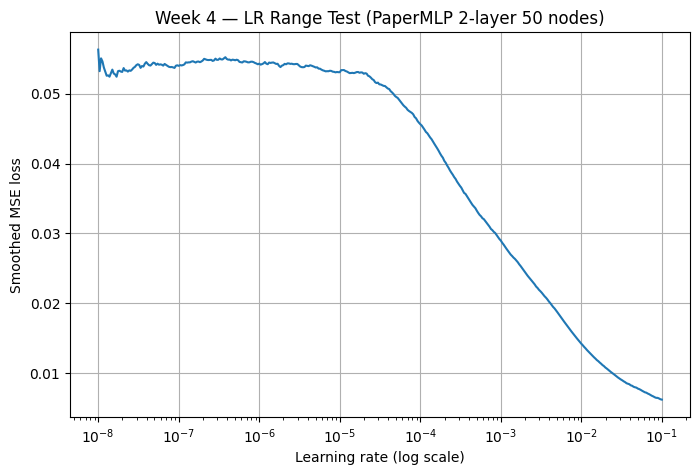

Saved: runs/week4_mlp_lr_search_and_paper_alignment/20260126-003223/figures/week4_lr_range_test.png
lr_high (min-loss): 0.09999999999999795
suggested training lr: 0.009999999999999796


In [ ]:
# =========================
# CELL 4.3 — LR Range Test (interpretable LR finder) + save plot + json
# =========================
def lr_range_test(
    model,
    train_loader,
    device,
    lr_start=1e-8,
    lr_end=1e-1,
    num_iter=400,
    beta=0.98,
    divergence_factor=4.0
):
    """
    LR Range Test:
      - start lr_start
      - multiply LR each iteration so we reach lr_end at num_iter
      - record smoothed loss
      - stop early if loss diverges
    Returns: lrs, losses
    """
    model = model.to(device)
    model.train()

    # save weights so test doesn't permanently change model
    init_state = copy.deepcopy(model.state_dict())

    optimizer = optim.Adam(model.parameters(), lr=lr_start)

    mult = (lr_end / lr_start) ** (1 / max(num_iter - 1, 1))

    avg_loss = 0.0
    best_loss = float("inf")
    lrs, losses = [], []

    it = 0
    loader_iter = iter(train_loader)

    while it < num_iter:
        try:
            batch = next(loader_iter)
        except StopIteration:
            loader_iter = iter(train_loader)
            batch = next(loader_iter)

        batch = batch.to(device)
        X = batch[:, :-1]
        y = batch[:, -1]

        lr = optimizer.param_groups[0]["lr"]
        lrs.append(lr)

        optimizer.zero_grad(set_to_none=True)
        yhat = model(X)
        loss = F.mse_loss(yhat, y)
        loss_val = loss.item()

        # smooth
        avg_loss = beta * avg_loss + (1 - beta) * loss_val
        smooth = avg_loss / (1 - beta ** (it + 1))
        losses.append(smooth)

        if smooth < best_loss:
            best_loss = smooth

        if smooth > divergence_factor * best_loss:
            print(f"Stopping early at iter={it}, lr={lr:.3e}, smooth_loss={smooth:.3e} (diverged)")
            break

        loss.backward()
        optimizer.step()

        optimizer.param_groups[0]["lr"] = lr * mult
        it += 1

    # restore weights
    model.load_state_dict(init_state)
    return lrs, losses


# Run LR test on a small-ish model (paper grid includes 2-layer 50 nodes)
lr_model = PaperMLP(hidden_layers=2, hidden_units=50).to(device)

lrs, losses = lr_range_test(
    lr_model,
    train_loader,
    device=device,
    lr_start=1e-8,
    lr_end=1e-1,
    num_iter=400,
    beta=0.98,
    divergence_factor=4.0
)

# plot
plt.figure(figsize=(8,5))
plt.plot(lrs, losses)
plt.xscale("log")
plt.xlabel("Learning rate (log scale)")
plt.ylabel("Smoothed MSE loss")
plt.title("Week 4 — LR Range Test (PaperMLP 2-layer 50 nodes)")
plt.grid(True)

lr_plot_path = os.path.join(fig_dir, "week4_lr_range_test.png")
plt.savefig(lr_plot_path, dpi=180, bbox_inches="tight")
plt.show()

print("Saved:", lr_plot_path)

# crude suggestion: lr at minimum smoothed loss, plus 10x lower
min_i = int(np.argmin(losses))
lr_high = float(lrs[min_i])
lr_suggest = lr_high / 10.0

print("lr_high (min-loss):", lr_high)
print("suggested training lr:", lr_suggest)

save_json(run_dir, "lr_range_test", {
    "lr_start": 1e-8,
    "lr_end": 1e-1,
    "num_iter_ran": len(lrs),
    "lr_high_min_loss": lr_high,
    "lr_suggest": lr_suggest,
    "note": "Paper uses lr=1e-5; LR finder is for sanity + understanding. For paper alignment, use lr=1e-5 in sweeps."
})

## Training BS-ANN

In [ ]:
# =========================
# CELL 4.4 — Train/eval helpers for paper sweep (MSE + training time)
# =========================

import time, os, glob

@torch.no_grad()
def eval_mse(model, loader, device):
    """Return average MSE over loader."""
    model.eval()
    sse = 0.0
    n = 0
    for batch in loader:
        batch = batch.to(device)
        X = batch[:, :-1]
        y = batch[:, -1]
        yhat = model(X)
        sse += F.mse_loss(yhat, y, reduction="sum").item()
        n += X.size(0)
    return sse / max(n, 1)


def find_latest_checkpoint(task_dir: str, tag: str):
    """
    Search for the newest checkpoint_{tag}.pt under:
      {task_dir}/*/checkpoint_{tag}.pt

    task_dir should match CELL 4.0 task folder:
      base_dir / task
    e.g. task_dir = "runs/week4_mlp_lr_search_and_paper_alignment"

    Returns:
      (ckpt_path, run_dir) or (None, None) if not found
    """
    pattern = os.path.join(task_dir, "*", f"checkpoint_{tag}.pt")
    matches = glob.glob(pattern)
    if not matches:
        return None, None

    # newest by modification time
    ckpt_path = max(matches, key=os.path.getmtime)
    run_dir = os.path.dirname(ckpt_path)
    return ckpt_path, run_dir


def train_fixed_epochs(
    model,
    train_loader,
    test_loader,
    device,
    lr,
    epochs=200,
    log_every=50,
    # --- Week 4 / CELL 4.0 alignment ---
    run_dir=None,          # default: use current run_dir from CELL 4.0
    fig_dir=None,          # default: use current fig_dir from CELL 4.0
    tag="model",           # e.g., "2L_50N"
    save_artifacts=True,
    checkpoint_every=1,    # ✅ safest
    resume=True,
    # --- NEW: auto-resume across old run folders ---
    auto_find_checkpoint=True,
    task_dir="runs/week4_mlp_lr_search_and_paper_alignment"  # matches CELL 4.0 task name
):

    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)

    # Ensure fig_dir exists if provided
    if fig_dir is not None:
        os.makedirs(fig_dir, exist_ok=True)

    # -------- Determine checkpoint path to use --------
    ckpt_path = os.path.join(run_dir, f"checkpoint_{tag}.pt") if run_dir is not None else None

    # If no checkpoint in current run_dir, optionally auto-find the latest one across task_dir
    if resume and save_artifacts and auto_find_checkpoint:
        needs_search = (ckpt_path is None) or (not os.path.exists(ckpt_path))
        if needs_search:
            found_ckpt, found_run = find_latest_checkpoint(task_dir=task_dir, tag=tag)
            if found_ckpt is not None:
                print("🔎 Found existing checkpoint in an older run folder:")
                print("   ", found_ckpt)
                # Switch run_dir/fig_dir to the folder containing the checkpoint
                run_dir = found_run
                fig_dir = os.path.join(run_dir, "figures")
                os.makedirs(fig_dir, exist_ok=True)
                ckpt_path = found_ckpt

    # Now define paths based on (possibly updated) run_dir
    ckpt_path = os.path.join(run_dir, f"checkpoint_{tag}.pt") if run_dir is not None else None
    best_path = os.path.join(run_dir, f"model_best_{tag}.pt") if run_dir is not None else None

    # ---- Resume state ----
    start_epoch = 1
    train_hist, test_hist = [], []
    best_test = float("inf")

    if resume and save_artifacts and ckpt_path is not None and os.path.exists(ckpt_path):
        ckpt = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(ckpt["model_state"])
        opt.load_state_dict(ckpt["opt_state"])
        start_epoch = int(ckpt["epoch"]) + 1
        train_hist = list(ckpt.get("train_curve", []))
        test_hist  = list(ckpt.get("test_curve", []))
        best_test  = float(ckpt.get("best_test_mse", float("inf")))
        print(f"✅ Resumed from checkpoint: {ckpt_path}")
        print(f"   last completed epoch = {ckpt['epoch']}  -> continuing at epoch {start_epoch}")
    else:
        if save_artifacts:
            print("ℹ️ No checkpoint found — training from scratch.")
            if run_dir is not None:
                print("   saving to:", run_dir)

    # ---- Training loop ----
    t0 = time.perf_counter()

    for ep in range(start_epoch, epochs + 1):
        model.train()
        for batch in train_loader:
            batch = batch.to(device)
            X = batch[:, :-1]
            y = batch[:, -1]

            opt.zero_grad(set_to_none=True)
            yhat = model(X)
            loss = F.mse_loss(yhat, y)
            loss.backward()
            opt.step()

        train_m = float(eval_mse(model, train_loader, device))
        test_m  = float(eval_mse(model, test_loader, device))
        train_hist.append(train_m)
        test_hist.append(test_m)

        # best weights
        if test_m < best_test:
            best_test = test_m
            if save_artifacts and best_path is not None:
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                torch.save(best_state, best_path)
                print(f"⭐ New best test MSE={best_test:.3e} at epoch {ep} -> saved {best_path}")

        # logging (screen only)
        if ep % log_every == 0 or ep in (1, epochs):
            print(f"epoch {ep:3d}/{epochs} | train MSE={train_m:.3e} | test MSE={test_m:.3e}")

        # checkpoint (OVERWRITES SAME FILE)
        if save_artifacts and ckpt_path is not None and (ep % checkpoint_every == 0):
            ckpt = {
                "epoch": int(ep),
                "model_state": {k: v.detach().cpu().clone() for k, v in model.state_dict().items()},
                "opt_state": opt.state_dict(),
                "train_curve": [float(x) for x in train_hist],
                "test_curve":  [float(x) for x in test_hist],
                "best_test_mse": float(best_test),
                "lr": float(lr),
                "epochs": int(epochs),
                "tag": str(tag),
                "seed": int(SEED),
            }
            torch.save(ckpt, ckpt_path)

            # progress snapshot (overwritten)
            if run_dir is not None:
                save_json(run_dir, f"metrics_progress_{tag}", {
                    "epoch": int(ep),
                    "train_mse": float(train_m),
                    "test_mse": float(test_m),
                    "best_test_mse": float(best_test),
                    "lr": float(lr),
                    "tag": str(tag),
                })

    t1 = time.perf_counter()
    seconds = float(t1 - t0)

    out = {
      "lr": float(lr),
      "epochs": int(epochs),

      # --- timing (match what Cell 4.5 expects) ---
      "train_seconds": seconds,
      "train_hours": float(seconds / 3600.0),

      # --- final metrics ---
      "train_mse_final": float(train_hist[-1]) if len(train_hist) else None,
      "test_mse_final": float(test_hist[-1]) if len(test_hist) else None,
      "best_test_mse": float(best_test),

      # --- curves ---
      "train_curve": [float(x) for x in train_hist],
      "test_curve": [float(x) for x in test_hist],

      # --- bookkeeping ---
      "tag": str(tag),
      "device": str(device),
      "torch_num_threads": int(torch.get_num_threads()),
      "start_epoch_used": int(start_epoch),
      "completed_epochs_total": int(len(train_hist)),
      "checkpoint_path": ckpt_path,
      "best_model_path": best_path,
      "run_dir_used": run_dir,
      "fig_dir_used": fig_dir,
    }

    # final summary + plot
    if save_artifacts and run_dir is not None:
        save_json(run_dir, f"metrics_{tag}", out)

        if fig_dir is not None:
            os.makedirs(fig_dir, exist_ok=True)
            plt.figure(figsize=(8, 5))
            plt.plot(train_hist, label="train MSE")
            plt.plot(test_hist, label="test MSE")
            plt.xlabel("Epoch")
            plt.ylabel("MSE")
            plt.title(f"Train/Test MSE vs Epoch ({tag})")
            plt.grid(True)
            plt.legend()
            curve_path = os.path.join(fig_dir, f"mse_curves_{tag}.png")
            plt.savefig(curve_path, dpi=180, bbox_inches="tight")
            plt.show()
            print("Saved:", curve_path)

    return out

In [ ]:
# =========================
# CELL 4.5 — Paper-aligned 12-model sweep (Table 6.15 -> Figure 6.16 data)
# Enhanced to load existing results if already complete, otherwise trains/resumes.
# =========================

# Ensure run_dir and fig_dir are defined from the previous step's execution
# (Expected to be set by running the 'Set Existing Run Context' cell, e.g., 74a964d9)
import json
import os
import pandas as pd

print(f"Using run_dir: {run_dir}")

layers_list = [2, 3]
nodes_list  = [50, 100, 150, 200, 250, 500]

# Generate all expected tags to check for full completion
all_tags = []
for H in nodes_list:
    for L in layers_list:
        all_tags.append(f"{L}L_{H}N")

all_models_finished = True
for tag in all_tags:
    final_path = os.path.join(run_dir, f"metrics_{tag}.json")
    if not os.path.exists(final_path):
        all_models_finished = False
        break

results = []

if all_models_finished:
    print("All models previously trained. Loading existing results...")
    for tag in all_tags: # Iterate through all tags to load their json
        filepath = os.path.join(run_dir, f"metrics_{tag}.json")
        try:
            with open(filepath, 'r') as f:
                data = json.load(f)
            parts = tag.split('_')
            L = int(parts[0][:-1])
            H = int(parts[1][:-1])

            results.append({
                "label": f"{L} layers {H} nodes",
                "layers": L,
                "nodes": H,
                "tag": tag,
                "train_hours": data.get("train_hours"),
                "test_mse": data.get("test_mse_final"),
                "train_mse": data.get("train_mse_final"),
                "train_curve": data.get("train_curve"),
                "test_curve": data.get("test_curve"),
            })
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
else:
    print("Some models are incomplete or need training. Proceeding with training/resume logic...")
    # IMPORTANT: for timing comparability, keep CPU single thread (already set)
    # Also: for paper alignment, fix lr=1e-5, batch=64, epochs=200
    for H in nodes_list:
        for L in layers_list:  # order: 2-layer then 3-layer for each H (matches paper axis style)
            label = f"{L} layers {H} nodes"
            print("\n====", label, "====")

            model = PaperMLP(hidden_layers=L, hidden_units=H)

            tag = f"{L}L_{H}N"  # unique per model, e.g., "2L_50N"

            final_path = os.path.join(run_dir, f"metrics_{tag}.json")

            # If the final metrics file exists, this model already finished; skip its training.
            if os.path.exists(final_path):
                print(f"✅ Skipping {tag} (already finished): {final_path}")
                # Load the data for this already finished model and add to results
                try:
                    with open(final_path, 'r') as f:
                        data = json.load(f)
                    results.append({
                        "label": label,
                        "layers": L,
                        "nodes": H,
                        "tag": tag,
                        "train_hours": data.get("train_hours"),
                        "test_mse": data.get("test_mse_final"),
                        "train_mse": data.get("train_mse_final"),
                        "train_curve": data.get("train_curve"),
                        "test_curve": data.get("test_curve"),
                    })
                except Exception as e:
                    print(f"Error loading {final_path} for skipped model: {e}")
                continue # Skip calling train_fixed_epochs if already finished


            out = train_fixed_epochs(
                model,
                train_loader,
                test_loader,
                device=device,
                lr=PAPER_LR,
                epochs=PAPER_EPOCHS,
                log_every=50,
                run_dir=run_dir,             # ✅ save into this Week 4 run folder
                fig_dir=fig_dir,             # ✅ save curves into this figures folder
                tag=tag,                     # ✅ makes checkpoint filenames unique per model
                checkpoint_every=1,          # ✅ safest (writes one rolling checkpoint file)
                resume=True,                 # ✅ resume if notebook crashes mid-model
                auto_find_checkpoint=False   # ✅ DO NOT mix with older runs during sweep
            )

            results.append({
            "label": label,
            "layers": L,
            "nodes": H,
            "tag": tag,
            "train_hours": out["train_hours"],
            "test_mse": out["test_mse_final"],
            "train_mse": out["train_mse_final"],
            "train_curve": out["train_curve"],
            "test_curve": out["test_curve"],
            })

df = pd.DataFrame(results)

# Save raw results (without huge curves) as json summary
save_json(run_dir, "paper_sweep_summary", {
    "lr": PAPER_LR, # These global variables should be available from CELL 4.2
    "batch": PAPER_BATCH, # from CELL 4.2
    "epochs": PAPER_EPOCHS, # from CELL 4.2
    "device": str(device), # from CELL 4.2
    "torch_num_threads": int(torch.get_num_threads()), # from CELL 4.2
    "rows": [
        {"label": r["label"], "layers": int(r["layers"]), "nodes": int(r["nodes"]),
         "train_hours": float(r["train_hours"]), "test_mse": float(r["test_mse"])}
        for _, r in df.iterrows()
    ]
})

# Also save full dataframe as CSV (includes curves? keep it small: drop curves)
df_small = df.drop(columns=["train_curve", "test_curve"])
csv_path = os.path.join(run_dir, "week4_paper_mlp_sweep.csv")
df_small.to_csv(csv_path, index=False)
print("Saved:", csv_path)

display(df_small)

Using run_dir: runs/week4_mlp_lr_search_and_paper_alignment/20260126-003223
All models previously trained. Loading existing results...
Saved: runs/week4_mlp_lr_search_and_paper_alignment/20260126-003223/week4_paper_mlp_sweep.csv


,label,layers,nodes,tag,train_hours,test_mse,train_mse
0,2 layers 50 nodes,2,50,2L_50N,0.123940,2.789249e-06,2.767186e-06
1,3 layers 50 nodes,3,50,3L_50N,0.141425,2.308291e-06,2.282548e-06
2,2 layers 100 nodes,2,100,2L_100N,0.135535,8.719681e-07,8.516561e-07
3,3 layers 100 nodes,3,100,3L_100N,0.164692,5.470124e-07,5.238315e-07
4,2 layers 150 nodes,2,150,2L_150N,0.157170,4.445163e-07,4.324675e-07
5,3 layers 150 nodes,3,150,3L_150N,0.201700,3.833236e-07,3.664263e-07
6,2 layers 200 nodes,2,200,2L_200N,0.168198,2.287168e-07,2.151874e-07
7,3 layers 200 nodes,3,200,3L_200N,0.238827,1.826171e-07,1.704996e-07
8,2 layers 250 nodes,2,250,2L_250N,0.200454,1.949413e-07,1.865344e-07
9,3 layers 250 nodes,3,250,3L_250N,0.317977,5.378618e-07,5.226418e-07


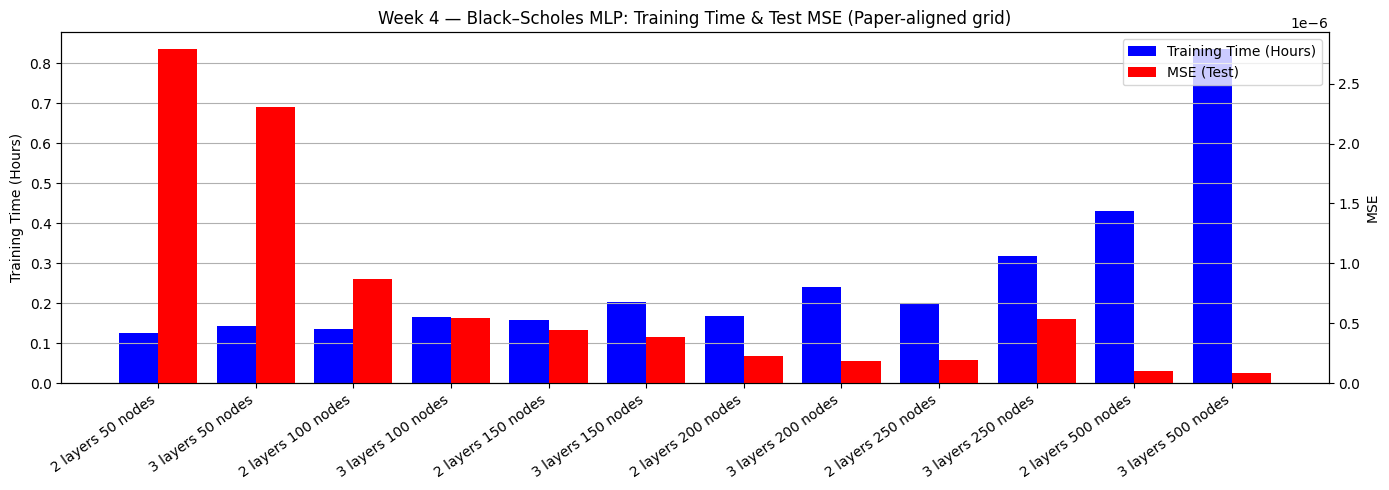

Saved: runs/week4_mlp_lr_search_and_paper_alignment/20260126-003223/figures/week4_fig6_16_style_time_vs_mse.png


In [ ]:
# =========================
# CELL 4.6 — Two-sided bar chart (Figure 6.16 in paper)
# =========================
labels = df["label"].tolist()
x = np.arange(len(labels))

train_hours = df["train_hours"].values
test_mse = df["test_mse"].values

fig, ax1 = plt.subplots(figsize=(14, 5))
ax2 = ax1.twinx()

bar_w = 0.40
ax1.bar(x - bar_w/2, train_hours, width=bar_w, label="Training Time (Hours)", color='blue')
ax2.bar(x + bar_w/2, test_mse,    width=bar_w, label="MSE (Test)", color='red')

ax1.set_ylabel("Training Time (Hours)")
ax2.set_ylabel("MSE")
ax1.set_title("Week 4 — Black–Scholes MLP: Training Time & Test MSE (Paper-aligned grid)")
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=35, ha="right")
ax1.grid(True, axis="y")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc="upper right") # Changed legend location to 'upper right'

plt.tight_layout()

fig_path = os.path.join(fig_dir, "week4_fig6_16_style_time_vs_mse.png")
plt.savefig(fig_path, dpi=180, bbox_inches="tight")
plt.show()

print("Saved:", fig_path)

Saved: runs/week4_mlp_lr_search_and_paper_alignment/20260126-003223/figures/week4_train_curves_2layer_50_250_500.png


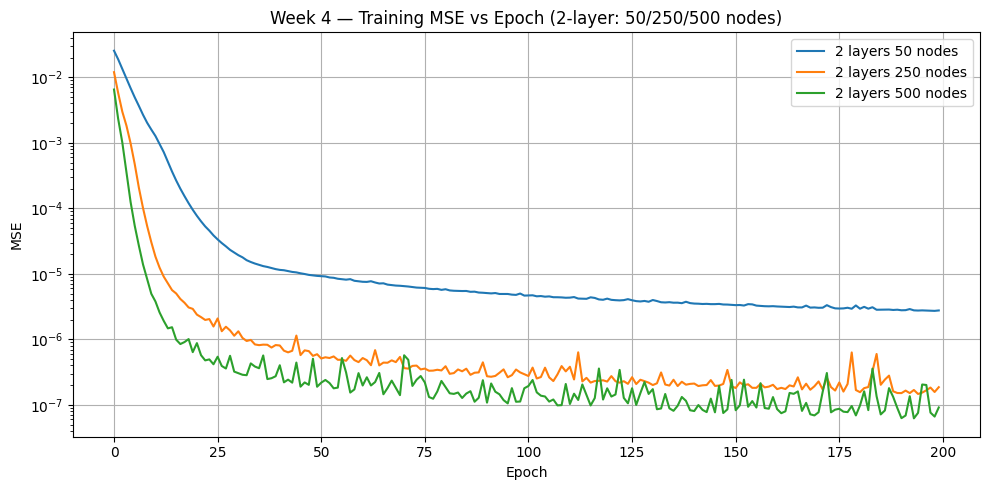

Saved: runs/week4_mlp_lr_search_and_paper_alignment/20260126-003223/figures/week4_test_curves_2layer_50_250_500.png


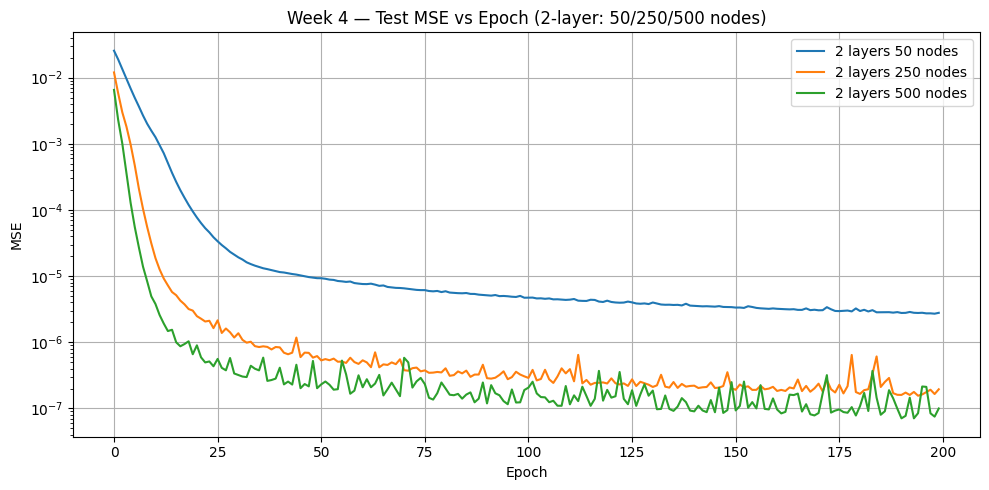

Saved: runs/week4_mlp_lr_search_and_paper_alignment/20260126-003223/figures/week4_train_curves_3layer_50_250_500.png


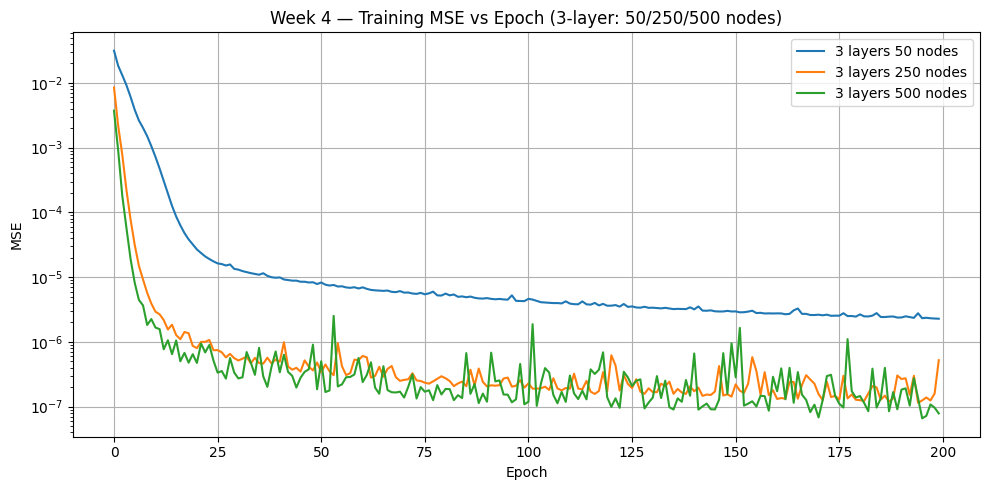

Saved: runs/week4_mlp_lr_search_and_paper_alignment/20260126-003223/figures/week4_test_curves_3layer_50_250_500.png


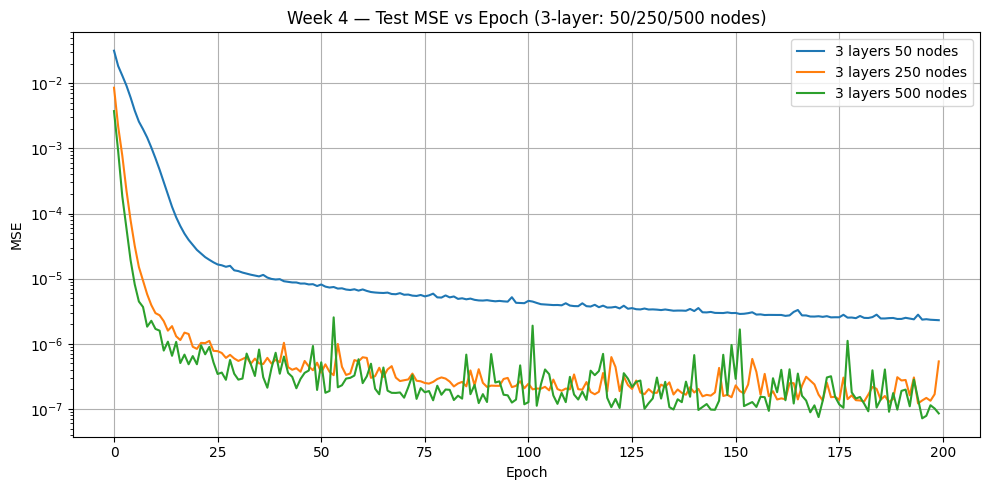

In [ ]:
# =========================
# CELL 4.7 — MSE Loss vs epochs for train/test data
# =========================
def plot_curves(df, configs, which="train_curve", title="", yscale='linear', save_path=None):
    plt.figure(figsize=(10, 5))
    for (L, H) in configs:
        row = df[(df.layers == L) & (df.nodes == H)].iloc[0]
        plt.plot(row[which], label=f"{L} layers {H} nodes")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    if yscale == 'log':
        plt.yscale('log')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=180, bbox_inches="tight")
        print("Saved:", save_path)
    plt.show()

# --- 2-layer network plots ---
configs_2layer = [(2, 50), (2, 250), (2, 500)]

# Plot and save Training MSE curves with logarithmic y-scale
train_curve_path_2layer = os.path.join(fig_dir, "week4_train_curves_2layer_50_250_500.png")
plot_curves(df, configs_2layer, which="train_curve",
            title="Week 4 — Training MSE vs Epoch (2-layer: 50/250/500 nodes)",
            yscale='log', save_path=train_curve_path_2layer)

# Plot and save Test MSE curves with logarithmic y-scale
test_curve_path_2layer = os.path.join(fig_dir, "week4_test_curves_2layer_50_250_500.png")
plot_curves(df, configs_2layer, which="test_curve",
            title="Week 4 — Test MSE vs Epoch (2-layer: 50/250/500 nodes)",
            yscale='log', save_path=test_curve_path_2layer)

# --- 3-layer network plots ---
configs_3layer = [(3, 50), (3, 250), (3, 500)]

# Plot and save Training MSE curves for 3-layer networks
train_curve_path_3layer = os.path.join(fig_dir, "week4_train_curves_3layer_50_250_500.png")
plot_curves(df, configs_3layer, which="train_curve",
            title="Week 4 — Training MSE vs Epoch (3-layer: 50/250/500 nodes)",
            yscale='log', save_path=train_curve_path_3layer)

# Plot and save Test MSE curves for 3-layer networks
test_curve_path_3layer = os.path.join(fig_dir, "week4_test_curves_3layer_50_250_500.png")
plot_curves(df, configs_3layer, which="test_curve",
            title="Week 4 — Test MSE vs Epoch (3-layer: 50/250/500 nodes)",
            yscale='log', save_path=test_curve_path_3layer)


In [ ]:
# =========================
# CELL 4.8 — Week 4 Summary Notes (saved to run folder)
# =========================
summary = f"""
Week 4 Summary (Paper alignment: MLP + LR search):

(1) LR Range Test:
- Ran an exponential LR range test on a small paper-aligned model (2 layers, 50 nodes).
- Saved LR-vs-loss plot: {os.path.join(fig_dir, "week4_lr_range_test.png")}
- Suggested LR from min-loss heuristic (for intuition), but for strict paper replication we fix lr = 1e-5.

(2) Paper-aligned MLP sweep (Table 6.15 grid):
- Trained 12 networks: layers in {{2,3}} × nodes in {{50,100,150,200,250,500}}
- Activation: ReLU | Loss: MSE | Epochs: {PAPER_EPOCHS} | Batch: {PAPER_BATCH} | LR: {PAPER_LR}
- Timing setup: CPU with torch.set_num_threads(1) for comparability
- Saved CSV: {os.path.join(run_dir, "week4_paper_mlp_sweep.csv")}
- Saved Figure 6.16-style plot: {os.path.join(fig_dir, "week4_fig6_16_style_time_vs_mse.png")}

(3) Optional curves:
- Plotted train/test MSE vs epoch for 2-layer networks with 50/250/500 nodes to mirror the paper’s discussion.
""".strip()

with open(os.path.join(run_dir, "notes_week4_summary.md"), "w") as f:
    f.write(summary + "\n")

print("Saved summary to:", os.path.join(run_dir, "notes_week4_summary.md"))
print("\n" + summary)

Saved summary to: runs/week4_mlp_lr_search_and_paper_alignment/20260126-003223/notes_week4_summary.md

Week 4 Summary (Paper alignment: MLP + LR search):

(1) LR Range Test:
- Ran an exponential LR range test on a small paper-aligned model (2 layers, 50 nodes).
- Saved LR-vs-loss plot: runs/week4_mlp_lr_search_and_paper_alignment/20260126-003223/figures/week4_lr_range_test.png
- Suggested LR from min-loss heuristic (for intuition), but for strict paper replication we fix lr = 1e-5.

(2) Paper-aligned MLP sweep (Table 6.15 grid):
- Trained 12 networks: layers in {2,3} × nodes in {50,100,150,200,250,500}
- Activation: ReLU | Loss: MSE | Epochs: 200 | Batch: 64 | LR: 1e-05
- Timing setup: CPU with torch.set_num_threads(1) for comparability
- Saved CSV: runs/week4_mlp_lr_search_and_paper_alignment/20260126-003223/week4_paper_mlp_sweep.csv
- Saved Figure 6.16-style plot: runs/week4_mlp_lr_search_and_paper_alignment/20260126-003223/figures/week4_fig6_16_style_time_vs_mse.png

(3) Optional cu